In [1]:
import json
import os
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import math
import pickle

from numpy.random import seed
from tensorflow import random

In [2]:
DATA_DIR2 = './data8/'
ids = os.listdir(DATA_DIR2)
pvm_angels = []
json_fps = [os.path.join(DATA_DIR2, image_id) for image_id in ids if image_id.startswith('catalog') and image_id.endswith('catalog')]
for file in json_fps:
    with open(file, 'r') as f:
        for line in f:            
            if (line.startswith('{')):
                jsonObj = json.loads(line)   
                imgFile = jsonObj['cam/image_array']
                path = os.path.join(DATA_DIR2, 'images', imgFile)
                throttle = jsonObj['user/throttle']
                if throttle != 0.0 and os.path.exists(path) :
                    image = cv2.imread(path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
                    #image = image[65:200, :]
                    #image = cv2.resize(image, (60,35))
                    image = cv2.resize(image, None, fx=0.25, fy= 0.25)
                    #image = cv2.resize(image, (60,60))
                    jsonObj['image'] = image
                    pvm_angels.append(jsonObj)


In [3]:
import albumentations as A

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, brightness_by_max=False, p=1),    
     A.OneOf(
        [
            #A.IAASharpen(p=1),
            A.Sharpen(p=1),
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.9,
    ),
])

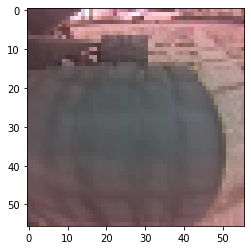

(56, 56, 3)

In [4]:
plt.imshow(pvm_angels[0]['image'])
plt.show()
pvm_angels[0]['image'].shape

In [13]:
#prepare and split data



df = pd.DataFrame(pvm_angels)

images = list(df['image'])
images = np.array(images) / 255.0
pwms = np.array(df['user/angle'])

images = images[4:] 
pwms = pwms[:-4]

angs = list(zip(images, pwms))
rnd.shuffle(angs)
images, pwms = zip(*angs)
images = np.array(images) 
pwms = np.array(pwms)

trainImagesX, testImagesX, trainPwmsX, testPwmsX = train_test_split(images, pwms, test_size=0.1, random_state=42)
trainImagesX, valImagesX, trainPwmsX, valPwmsX = train_test_split(trainImagesX, trainPwmsX, test_size=0.135, random_state=42)


In [14]:
#implment augmentation 
augmentedTrainImages = []
for i in range(len(trainImagesX)):
    orig_image = trainImagesX[i]
    augmentedTrainImages.append(orig_image)
    for j in range(9):
        augmentedTrainImages.append(transform(image=orig_image)['image'])

augmentedTrainImages = np.array(augmentedTrainImages)        
augmentedPwms = np.array(trainPwmsX).repeat(10)

augmentedTrainImages.shape, augmentedPwms.shape

((63790, 56, 56, 3), (63790,))

In [7]:
#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_d8_25_vgg.pickle', 'wb') as f:
    pickle.dump(data, f )

# Usage

In [15]:
def calc_ackerman(pwms):
    L = 178 #wheelbase
    b = 165 #

    theta = pwms
    R = L/(np.tan(np.radians(theta))+0.0000001)
    tg_alpha = L/(R+np.sign(theta)*b*25)
    alpha = np.degrees(np.arctan(tg_alpha))

    return alpha

def conv_sigmoid(pwms):
    return (pwms+1)/2.0

#LOAD DATA
with open('car_aug_data_25_vgg.pickle', 'rb') as f:
    data = pickle.load(f)
(augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX) = data


augmentedPwms = calc_ackerman(augmentedPwms)
valPwmsX = calc_ackerman(valPwmsX)
testPwmsX = calc_ackerman(testPwmsX)




In [16]:
augmentedPwms = conv_sigmoid(augmentedPwms)
valPwmsX = conv_sigmoid(valPwmsX)
testPwmsX = conv_sigmoid(testPwmsX)

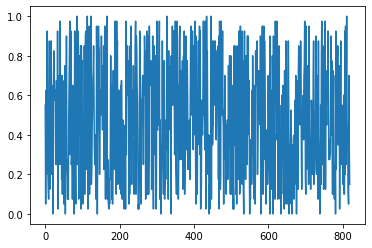

In [17]:
plt.plot(testPwmsX)

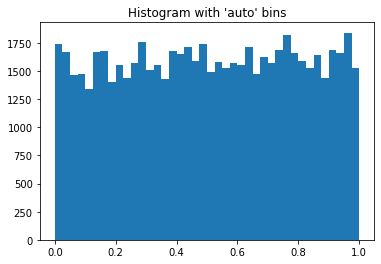

In [18]:
_ = plt.hist(augmentedPwms, bins=40)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [19]:
seed_value= 0
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

input_shape = augmentedTrainImages[0].shape

model = tf.keras.applications.VGG16(
weights='imagenet',
input_shape=input_shape,
include_top=False
)

for layer in model.layers:
      layer.trainable = False
        
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=model.input, outputs=x)

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x=augmentedTrainImages,y=augmentedPwms,  validation_data=(valImagesX, valPwmsX), epochs=50)

2022-12-15 13:53:01.497269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Epoch 1/50
1994/1994 [==============================] - 12s 5ms/step - loss: 0.0370 - val_loss: 0.0223
Epoch 2/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0249 - val_loss: 0.0188
Epoch 3/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0217 - val_loss: 0.0196
Epoch 4/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0197 - val_loss: 0.0146
Epoch 5/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0180 - val_loss: 0.0141
Epoch 6/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0172 - val_loss: 0.0142
Epoch 7/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0164 - val_loss: 0.0144
Epoch 8/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0154 - val_loss: 0.0131
Epoch 9/50
1994/1994 [==============================] - 10s 5ms/step - loss: 0.0152 - val_loss: 0.0124
Epoch 10/50
1994/1994 [==============================] - 10s 5ms/step - l

In [66]:
model.save('25_vgg_d8_move.model')

INFO:tensorflow:Assets written to: 25_vgg_d8_move.model/assets


INFO:tensorflow:Assets written to: 25_vgg_d8_move.model/assets


#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_25_vgg.pickle', 'wb') as f:
    pickle.dump(data, f )

import  tensorflow.keras.models
model = tensorflow.keras.models.load_model('25_vgg_d8_move.model')

In [20]:
score = model.evaluate(testImagesX, testPwmsX, verbose=0)
print('Test loss:', score)


Test loss: 0.006372496485710144


In [19]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 11, 30, 15, 32, 5, 43407)

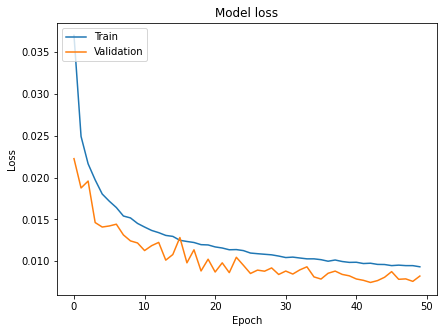

In [22]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [23]:
def show_pwm_prediction3(pwms, preditions, text, start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))    
    
    angs = list(zip(pwms.copy(), preditions))
    res = sorted(angs, key = lambda x: x[0])
    pwms, preditions  = zip(*res)
    
    data = zip()
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

          
    ax.plot(idxs, preditions, 'o', color="blue")
    ax.plot(idxs, pwms, 'o', color="green")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
    #print(pwms[5000], pwms[10000], pwms[15000],pwms[20000], pwms[25000], pwms[30000])
    #print(preditions[5000], preditions[10000], preditions[15000],preditions[20000], preditions[25000], preditions[30000])
    
    

26/26 [==============================] - 0s 4ms/step


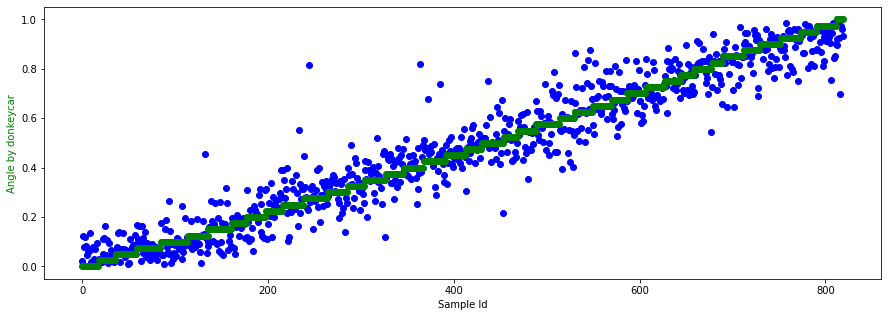

Sample count:  820
SSE 112534.12377405228


In [24]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX)
predictions2 = np.array(predictions)
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)

In [25]:
residuals = abs(predictions.flatten() - testPwmsX)

In [26]:
residuals.min(),residuals.max(),residuals.mean(), np.median(residuals), np.std(residuals)


(4.997253417982073e-05,
 0.5383164644241334,
 0.058126517331636554,
 0.043648598343133865,
 0.05471566294901879)

In [27]:
a = list(zip(testPwmsX, predictions, residuals))


(array([144., 122., 122.,  93.,  67.,  62.,  52.,  41.,  35.,  18.,  20.,
          7.,  13.,   3.,   2.,   5.,   1.,   2.,   4.,   0.,   0.,   1.,
          2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.99725342e-05, 1.35066348e-02, 2.69632971e-02, 4.04199594e-02,
        5.38766217e-02, 6.73332840e-02, 8.07899463e-02, 9.42466086e-02,
        1.07703271e-01, 1.21159933e-01, 1.34616596e-01, 1.48073258e-01,
        1.61529920e-01, 1.74986582e-01, 1.88443245e-01, 2.01899907e-01,
        2.15356569e-01, 2.28813232e-01, 2.42269894e-01, 2.55726556e-01,
        2.69183218e-01, 2.82639881e-01, 2.96096543e-01, 3.09553205e-01,
        3.23009868e-01, 3.36466530e-01, 3.49923192e-01, 3.63379855e-01,
        3.76836517e-01, 3.90293179e-01, 4.03749841e-01, 4.17206504e-01,
        4.30663166e-01, 4.44119828e-01, 4.57576491e-01, 4.71033153e-01,
        4.84489815e-01, 4.97946478e-01, 5.11403140e-01, 5.24859802e-01,
      

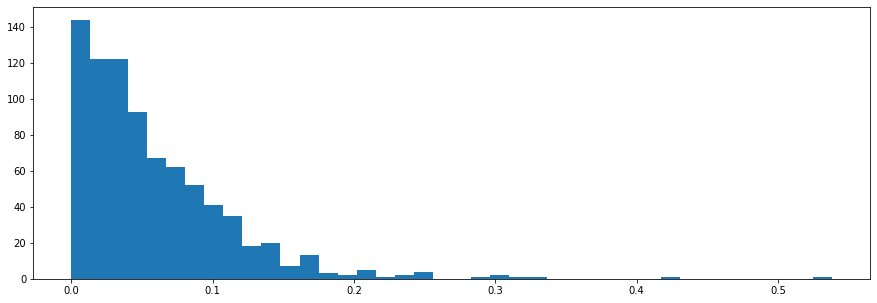

In [28]:
plt.hist(residuals, bins=40)

In [29]:
predictions=model.predict(augmentedTrainImages)

1994/1994 [==============================] - 8s 4ms/step


In [30]:
len(augmentedTrainImages)

63790

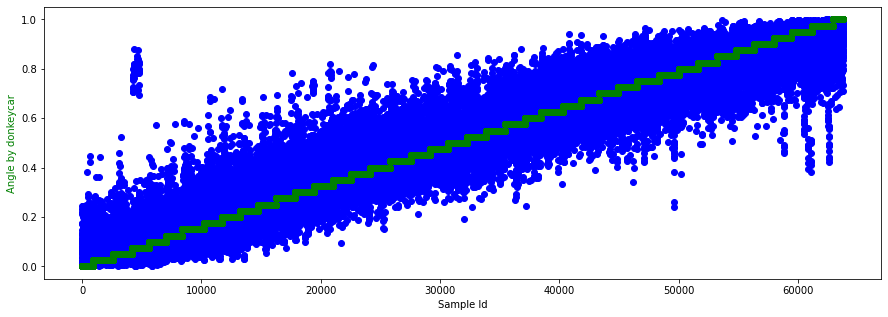

Sample count:  63790
SSE 8407424.19681572


In [31]:


pwms2 = np.array(augmentedPwms[0:])
predictions2 = np.array(predictions[0:])
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)


In [33]:
residuals2 = abs(predictions2.flatten() - augmentedPwms)

In [59]:
b = list(zip(residuals2, augmentedPwms, augmentedTrainImages, predictions2))
res = sorted(b, key = lambda x: x[0])
residuals3, augmentedPwms3, augmentedTrainImages3, predictions3  = zip(*res)
    
    

In [60]:

residuals3[-1]

0.8047151446342471

0.7450817704200747 0.07499999999999968 0.8200818


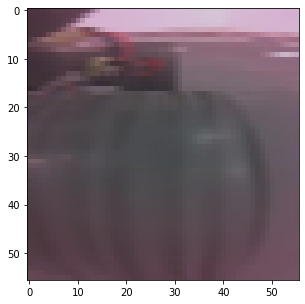

In [67]:
idx = -10
print(residuals3[idx], augmentedPwms3[idx], predictions3[idx][0])
plt.imshow(augmentedTrainImages3[idx])
plt.show()


(array([1740., 1670., 1460., 1470., 1340., 1670., 1680., 1400., 1550.,
        1440., 1570., 1760., 1510., 1550., 1430., 1680., 1650., 1710.,
        1590., 1740., 1490., 1580., 1530., 1570., 1550., 1710., 1470.,
        1620., 1570., 1690., 1820., 1660., 1590., 1530., 1640., 1440.,
        1690., 1660., 1840., 1530.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

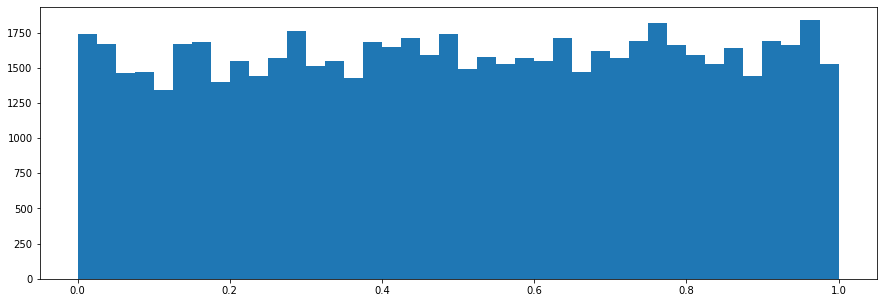

In [70]:
plt.hist(augmentedPwms3, bins=40)

In [21]:
def show_pwm_prediction(pwms, preditions, throttle, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, throttle, color="red")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle and Throttle by donkeycar', color="green")
    
    ax2 = ax.twinx()
    ax2.plot(idxs, preditions)
    ax2.set_ylabel('Angle by camera', color="blue")
    
    fig.set_figwidth(15)
    plt.show()

def show_pwm_prediction2(pwms, preditions, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, preditions, color="blue")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
def show_statistics(pwms, predictions, frames=None):

    #print('Sample count: ', len(predictions))
    #print('Cov', np.corrcoef([pwms,predictions]))    

    if frames == None:
        frames = len(predictions)
    predictions2 = predictions[:frames]
    mean = (max(predictions2) - min(predictions2))/2
    predictions3 = (predictions2 -  (min(predictions2) + mean) ) / mean
    #sse = np.sum(((predictions3 - pwms)**2))
    sse = np.sum(((predictions - pwms)**2))
    
    print('Sample count: ', len(predictions3))
    print('SSE', sse)

In [8]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-11-23 17:54:22.818577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
